In [124]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.activations
import sqlite3 as db
import datetime as dt
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
github_userName = 'Tanag3r'
ebird_token = 'j6c7l80ga2ib'
db_name = 'trailheadDirectBirds_sous.db'

In [3]:
##connect to database
def connectDB():
    try:
        cnx = db.connect(db_name)
    except Exception as cnxError:
        raise UserWarning(f'Unable to connect to database due to: {cnxError}')
    return cnx

In [4]:
#baseline request from the application layer
#outputs a list of birds at the stop and a classification based solely off the number of observations
def birdList_request(StopName: str,cnx):
    try:
        query = f'SELECT speciesCode,count(subId) as "checklists",(SELECT count(subId) FROM historicObservations hxobx WHERE hxobx.speciesCode=hsob.speciesCode) as "sightings" FROM historicObservations hsob LEFT JOIN closestStop on hsob.locId=closestStop.locId WHERE StopName = "{StopName}" GROUP BY speciesCode;'
        sightings = pd.read_sql(sql=query,con=cnx)
    #rareness at the stop
        sightings['stopGroup'] = int
        bucket = sightings['checklists'].quantile([0,0.15,0.5,0.85,1])
        sightings.loc[sightings['checklists'] <= bucket[0.15],'stopGroup'] = 1  #mythic
        sightings.loc[(sightings['checklists'] > bucket[0.15]) & (sightings['checklists'] <= bucket[0.5]),'stopGroup'] = 2  #rare
        sightings.loc[(sightings['checklists'] > bucket[0.5]) & (sightings['checklists'] < bucket[0.85]),'stopGroup'] = 3   #uncommon
        sightings.loc[(sightings['checklists'] >= bucket[0.85]) & (sightings['checklists'] <=bucket[1]),'stopGroup'] = 4    #common
    #overall rareness
        sightings['overall'] = int
        bucket = sightings['sightings'].quantile([0,0.15,0.5,0.85,1])
        sightings.loc[sightings['sightings'] <= bucket[0.15],'overall'] = 1
        sightings.loc[(sightings['sightings'] > bucket[0.15]) & (sightings['sightings'] <= bucket[0.5]),'overall'] = 2
        sightings.loc[(sightings['sightings'] > bucket[0.5]) & (sightings['sightings'] < bucket[0.85]),'overall'] = 3
        sightings.loc[(sightings['sightings'] >= bucket[0.85]) & (sightings['sightings'] <=bucket[1]),'overall'] = 4
        sightings['StopName'] = StopName
    #raise an exception if the stopName given is not valid and return a list of valid stop names
    except Exception as ex:
        raise ex
    return sightings

LSTM forecasting of common birds. Why use LSTM instead of a traditional auto-regression?
- Bird volumes at a time step are not neccessarily a function of volumes at the previous time step. It is not reasonable to assume that bird behavior (presence at a location) is explained by bird behavior in a historic time step.
- Comparatively less resource intensive. LSTM models can provide accurate forecasting without stepped re-training

How does LSTM perform compared to other NN autoregressive models? Not well in literature, but the above reasons make the method worth exploring

In [5]:
def build_dailyDataset(speciesCode: str,StopName: str,cnx = connectDB()):
    try:
        query = f'SELECT speciesCode,FX.locId,StopName,obsDt,howMany FROM historicObservations AS FX LEFT JOIN closestStop on FX.locId = closestStop.locId WHERE (SELECT count(distinct(subId)) FROM historicObservations AS QA WHERE QA.comName = FX.comName) > 2 AND FX.speciesCode = "{speciesCode}" AND StopName = "{StopName}";'
        obsData = pd.read_sql(query,con=cnx,parse_dates=['obsDt'])
        obsData.set_index('obsDt',inplace=True)
    #resample to days
        dailyData = obsData.resample('d')
        dailyData = dailyData.mean()
    except Exception as ex:
        raise ex
    return dailyData

In [13]:
##TODO build realtime prediction function using LSTM model

In [6]:
def build_interpolatedDataset(dailyData:pd.DataFrame):
    try:
    #mask in null presence
        dailyData['mask'] = dailyData['howMany'].interpolate(method='zero',limit_direction='both',limit=21)
        dailyData.loc[(dailyData['mask'].isna() == True),'howMany'] = 0
        test_dailyData = dailyData[dailyData['howMany'].notna()].drop(columns='mask')
        
#determine the best method of interpolation for the given data
        testResults = []
        methodDict = [{'method':'linear','order':3,'limit_direction':'both','limit':21},{'method':'slinear','order':3,'limit_direction':'both','limit':21},{'method':'quadratic','order':0,'limit_direction':'both','limit':21},{'method':'cubic','order':3,'limit_direction':'both','limit':21},{'method':'spline','order':3,'limit_direction':'both','limit':21},{'method':'spline','order':5,'limit_direction':'both','limit':21},{'method':'polynomial','order':3,'limit_direction':'both','limit':21},{'method':'polynomial','order':5,'limit_direction':'both','limit':21}]
        for v in list([0.2,0.25,0.3,0.35]):
            test_dailyData['sample'] = test_dailyData['howMany'].sample(frac=v,random_state=1)
            blob = {}
            for test in methodDict:
                testName = str(test['method'])
                test_dailyData[testName] = test_dailyData['sample']
                test_dailyData[testName] = test_dailyData['sample'].interpolate(method=test['method'],order=test['order'],limit=test['limit'],limit_direction=test['limit_direction']).fillna(test_dailyData['howMany'])
                r_sqr = r2_score(y_true=test_dailyData['howMany'],y_pred=test_dailyData[testName])
                if r_sqr < 0:
                    continue
                blob = {'method':test['method'],'order':test['order'],'limit':test['limit'],'sampleSize':v,'r_sqr':r_sqr}
                testResults.append(blob)
        if not testResults:
            testResults.append({'method':'nearest','order':0,'limit':21})
            resultFrame = pd.DataFrame.from_dict(testResults)
        else:
            resultFrame = pd.DataFrame.from_dict(testResults)
            resultFrame = resultFrame.groupby(by=['method','order','limit'])['r_sqr'].median().reset_index()
            resultFrame.sort_values(by=['r_sqr'],ascending=False,inplace=True,ignore_index=True)
    #apply the best interpolation method
        bestMethod = resultFrame.loc[0].to_dict()
        dailyData['howMany'] = dailyData['howMany'].interpolate(method=bestMethod['method'],order=bestMethod['order'],limit=bestMethod['limit'],limit_direction='both')
        dailyData.drop(columns='mask',inplace=True)
    except Exception as ex:
        raise ex
    return dailyData

In [185]:
def trim_DatasetDates(dailyData: pd.DataFrame,nInput:int):
    try:
        if (len(dailyData)/nInput).is_integer()!=True:
            i = 0
            for i in range(1,nInput-1):
                dailyDataCut = dailyData[i:]
                if (len(dailyDataCut)/nInput).is_integer()==True:
                    dailyDataCut
                    break
                else:
                    continue
        else:
            dailyDataCut = dailyData
            pass
    except Exception as ee:
        raise ee
    return dailyDataCut     

In [186]:
def split_trainTest(dailyObs,nInput:int):
    dailyObs = trim_DatasetDates(dailyData=dailyObs,nInput=nInput)
    train, test = dailyObs[1:-328],dailyObs[-328:-6]
    train = np.array(np.split(train,len(train)/7))
    test = np.array(np.split(test,len(test)/7))
    return train, test

In [9]:
#build forward-moving windows
def to_supervised(train,nInput,nOut = 7):
    train = train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
    X, y = [],[]
    inStart = 0
    for _ in range(len(train)):
        inEnd = inStart + nInput
        outEnd = inEnd + nOut
        if outEnd <= len(train):
            xIn = train[inStart:inEnd,0]
            xIn = xIn.reshape((len(xIn),1))
            X.append(xIn)
            y.append(train[inEnd:outEnd,0])
        inStart+= 1
    return np.array(X),np.array(y)

In [10]:
from keras.layers import RepeatVector,TimeDistributed

In [139]:
def build_basicLinearModel(train,nInput):
    train_x,train_y = to_supervised(train,nInput)
    verbose, epochs, batch_size = 0,70,16
    nTimesteps,nFeatures,nOutputs = train_x.shape[1],train_x.shape[2],train_y.shape[1]
    model = Sequential()
    model.add(LSTM(units=200,activation='relu', input_shape=(nTimesteps,nFeatures)))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(nOutputs))
    model.compile(loss='mse',optimizer='adam')
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

In [12]:
def build_basicLogisticModel(train,nInput):
    train_x,train_y = to_supervised(train,nInput)
    verbose, epochs, batch_size = 0,70,16
    nTimesteps,nFeatures,nOutputs = train_x.shape[1],train_x.shape[2],train_y.shape[1]
    model = Sequential()
    model.add(LSTM(units=200, input_shape=(nTimesteps,nFeatures)))
    model.add(Dense(100))
    model.add(Dense(nOutputs))
    model.compile(loss='mse',optimizer='adam')
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose)
    return model

In [138]:
def build_EncDecModel(train,nInput):
    try:
        train_x,train_y = to_supervised(train,nInput)
        verbose,epochs,batch_size = 0,20,16
        nTimesteps,nFeatures,nOutputs = train_x.shape[1],train_x.shape[2],train_y.shape[1]
    #output reshape
        train_y = train_y.reshape((train_y.shape[0],train_y.shape[1],1))
        model = Sequential()
        model.add(LSTM(200,activation='relu',input_shape=(nTimesteps,nFeatures)))
        model.add(RepeatVector(nOutputs))
        model.add(LSTM(200,activation='relu',return_sequences=True))
        model.add(TimeDistributed(Dense(100,activation='relu')))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mse',optimizer='adam')
        model.fit(train_x,train_y,batch_size=batch_size,verbose=verbose,epochs=epochs)
    except Exception as ex:
        raise ex
    return model

In [22]:
##TODO: build another model using encoder-decoder, run tests
##TODO export models to db
##TODO #97 build distinct LSTM models with different activation methods and learning rates, looking for responsiveness to volatility

In [68]:
def forecast(model,history,nInput):
    histData = np.array(history)
    histData = histData.reshape((histData.shape[0]*histData.shape[1],histData.shape[2]))
    inputX = histData[-nInput:,0]
    inputX = inputX.reshape((1,len(inputX),1))
    yhat = model.predict(inputX,verbose=0)
    yhat = yhat[0]
    return yhat

In [15]:
def forecast_fromDF(model,history,nInput):
    histData = np.array(history)
    histData = np.array(np.split(histData,len(histData)/7))
    histData = histData.reshape((histData.shape[0]*histData.shape[1],histData.shape[2]))
    inputX = histData[-nInput:,0]
    inputX = inputX.reshape((1,len(inputX),1))
    yhat = model.predict(inputX,verbose=0)
    yhat = yhat[0]
    return yhat

In [16]:
def eval_forecasts(actual,predicted):
    try:
        scores = list()
        for i in range(actual.shape[1]):
            mse = mean_squared_error(actual[:,i],predicted[:,i])
            rmse = np.sqrt(mse)
            scores.append(rmse)
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                s+= (actual[row,col] - predicted[row,col])**2
        score = np.sqrt(s/(actual.shape[0]*actual.shape[1]))
    except Exception as metricExc:
        raise metricExc
    return score, scores

In [21]:
def evalModel(train,test,nInput):
    model = build_basicModel(train=train,nInput=nInput)
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
        yhatSeq = forecast(model=model,history=history,nInput=nInput)
        predictions.append(yhatSeq)
        history.append(test[i,:])
    predictions = np.array(predictions)
    score, scores = eval_forecasts(actual=test[:,:,0],predicted=predictions)
    return score, scores
    #return predictions

In [17]:
def eval_givenModel(train,test,model,nInput):
    model = model
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
        yhatSeq = forecast(model=model,history=history,nInput=nInput)
        predictions.append(yhatSeq)
        history.append(test[i,:])
    predictions = np.array(predictions)
    score, scores = eval_forecasts(actual=test[:,:,0],predicted=predictions)
    return score, scores

In [18]:
def summarizeEvalScore(name,score,scores):
    sScores = ', '.join(['%f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, sScores))

In [204]:
def plot_forecast(model,modelName: str,history,nInput: int):
    try:
        history,predictions = trim_DatasetDates(dailyData=history,nInput=nInput),[]
        fxDist = int(len(history))
        s = 0
        for s in range(0,fxDist,nInput):
            grip = np.array(history[s:s+nInput])
            grip = grip.reshape((1,len(grip),1))
            yhat = model.predict(grip,verbose=0)
            yhat = yhat[0]
            yhat = yhat.flatten()
            startDate = history[s:s+nInput].index[6]
            fxDates = pd.date_range(start=startDate,periods=7).to_numpy()
            rxf = pd.Series(data=yhat,index=fxDates)
            s += 7
            predictions.append(rxf)
        fxPlot = pd.concat(predictions,axis=0)
        fxPlot.name = modelName
    except Exception as ex:
        raise ex
    return fxPlot

Spotted Towhee (spotow) at Margaret's Way stop

In [19]:
commonCore = birdList_request(StopName='MargaretsWay',cnx=connectDB())
commonCore = commonCore[commonCore.apply(lambda x: (x['stopGroup']==4) and (x['overall']==4),axis=1)]

In [20]:
spotow_MargWay = build_dailyDataset(speciesCode='spotow',StopName='MargaretsWay')
spotow_MargWay = build_interpolatedDataset(dailyData=spotow_MargWay)

In [115]:
train, test = split_trainTest(dailyObs=spotow_MargWay,nInput=7)

In [23]:
ModelLog_spotow_MargWay = build_basicLogisticModel(train=train,nInput=7)

In [27]:
modelLin_spotow_margWay = build_basicLinearModel(train=train,nInput=7)

In [140]:
modelEncDec_spotow_margWay = build_EncDecModel(train=train,nInput=14)

In [194]:
linearPlot = plot_forecast(model=modelLin_spotow_margWay,modelName='LinearSpotow',history=spotow_MargWay,nInput=7)
logPlot = plot_forecast(model=ModelLog_spotow_MargWay,modelName='logSpotow',history=spotow_MargWay,nInput=7)
encDecPlot = plot_forecast(model=modelEncDec_spotow_margWay,modelName='linearEncDec_spotow',history=spotow_MargWay,nInput=14)

In [206]:
compareResults = pd.concat(objs=[linearPlot,logPlot,encDecPlot],axis=1)
spotowComparison = pd.merge(left=compareResults,left_on=compareResults.index,right=spotow_MargWay,right_on='obsDt',how='left')
spotowComparison = spotowComparison.set_index(keys='obsDt')

American Robin (amerob) at Margaret's Way

In [118]:
amerob_marWay = build_dailyDataset(speciesCode='amerob',StopName='MargaretsWay')
amerob_marWay = build_interpolatedDataset(dailyData=amerob_marWay)
train_amerob,test_amerob = split_trainTest(dailyObs=amerob_marWay)

In [119]:
modelLog_amerob_margWay = build_basicLogisticModel(train=train_amerob,nInput=7)

In [120]:
modelLin_amerob_margWay = build_basicLinearModel(train=train_amerob,nInput=7)

In [208]:
modelEncDecLin_amerob_margWay = build_EncDecModel(train=train_amerob,nInput=14)

In [209]:
amerob_encDecLinPlot = plot_forecast(model=modelEncDecLin_amerob_margWay,modelName='EncDec_amerob',history=amerob_marWay,nInput=14)
amerob_linearPlot = plot_forecast(model=modelLin_amerob_margWay,modelName='LinearAmerob',history=amerob_marWay,nInput=7)
amerob_logPlot = plot_forecast(model=modelLog_amerob_margWay,history=amerob_marWay,modelName='LogisticAmerob',nInput=7)

In [210]:
mergeForecasts = pd.concat(objs=[amerob_logPlot,amerob_encDecLinPlot,amerob_linearPlot],axis=1)
amerobComparison = pd.merge(left=mergeForecasts,left_on=mergeForecasts.index,right=amerob_marWay,right_on='obsDt',how='left')
amerobComparison.set_index(keys='obsDt',inplace=True)

In [ ]:
##TODO #94 build three-week forecasting method on top of LSTM model
##TODO #96 visualize results of the LSTM models

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

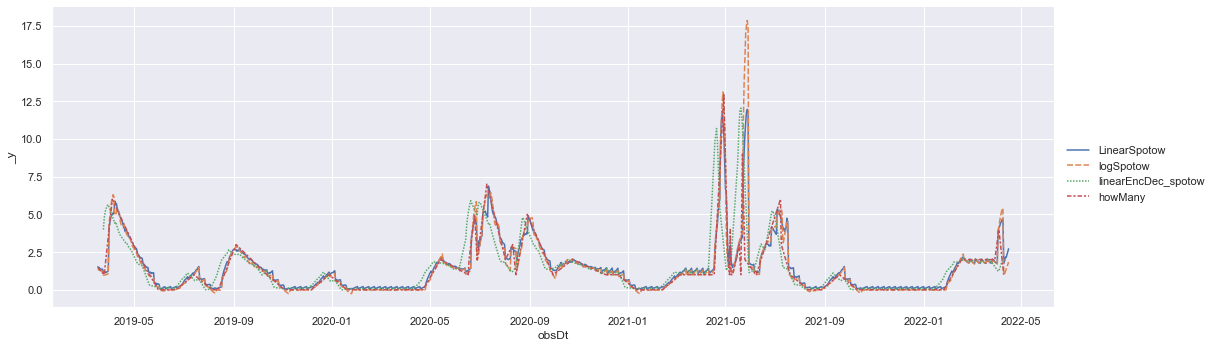

In [207]:
sns.relplot(data=spotowComparison,kind='line',ci=95,aspect=3.0)

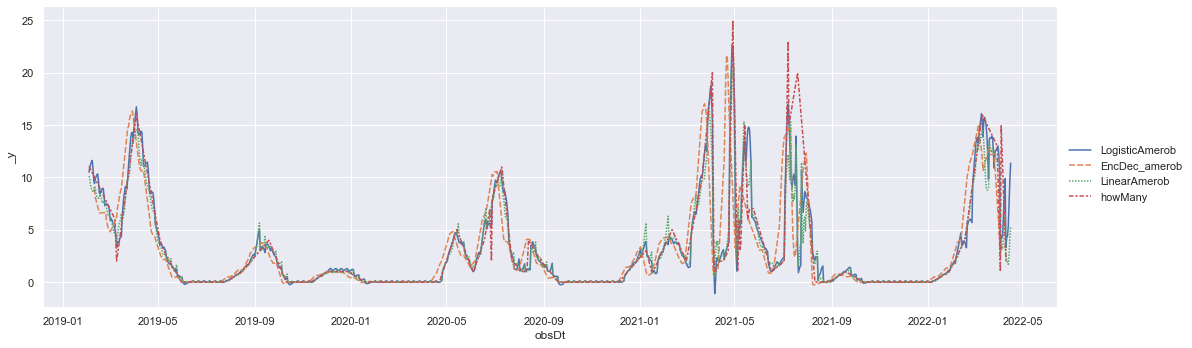

In [211]:
sns.relplot(data=amerobComparison,kind='line',aspect=3.0)